In [1]:
# !pip install pandapower==2.6.0
# print(pp.__version__)

import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import pandapower.converter as pc
from pypower.api import makeYbus
import time
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *
from pyomo.environ import value
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# from pandapower.results import calculate_voltage_dependent_losses

def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt

def _maxgap(points, input_space=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if input_space is not None:
        points = np.vstack((input_space.minimum, points, input_space.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = points[loc, np.arange(points.shape[1])]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width

In [130]:
# Load the IEEE 39-bus system from pandapower
net = pn.case39()

pp.to_excel(net, "network.xlsx")


In [136]:
#Load network
baseMVA = 100
net = pn.case39()
net.sn_mva = baseMVA
pp.runpp(net)
ppc = pp.converter.to_ppc(net)

# Calculate the Ybus matrix
# Ybus = net["_ppc"]["internal"]["Ybus"]
# Using pandas
# Ybus, Yf, Yt = makeYbus(baseMVA, ppc['bus'], ppc['branch'])
# or
xls = pd.ExcelFile('data/case39.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
bus_len = bus.shape[0]; gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len):  
    x[i] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i]['b'])/2)
for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)

#Get network elements
branch = net.line
gen = net.gen
bus = net.bus
load = net.load
cost = net.poly_cost

#Get all generators (+ external grid)
comb_gen = gen[list(net.ext_grid.columns.drop('va_degree'))]
comb_gen = pd.concat([comb_gen, net.ext_grid]).sort_values(by=['bus'])
gen_list = list(comb_gen.bus)

branch_len = len(branch); bus_len = len(bus); gen_len = len(comb_gen)

#Calculate Max MVA for branches
max_mva = []
for i in range(branch_len):
    max_mva.append(net.line.max_i_ka[i]*np.sqrt(3)*net.bus.iloc[int(net.line.from_bus[i])]['vn_kv']) 
branch['rateA'] = max_mva

# initialisation
Pd = np.zeros(bus_len); Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len); Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len); Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len); Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len); cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Vmax[i] = bus['max_vm_pu'][i]
    Vmin[i] = bus['min_vm_pu'][i]
for i,j in enumerate(load.bus):
    Pd[j] = load.p_mw.iloc[i]/baseMVA
    Qd[j] = load.q_mvar.iloc[i]/baseMVA
# Qd[Qd<0] = -1*Qd[Qd<0]
for i,j in enumerate(comb_gen.bus):
    Pmax[j] = comb_gen.max_p_mw.iloc[i]/baseMVA
    Pmin[j] = comb_gen.min_p_mw.iloc[i]/baseMVA
    Qmax[j] = comb_gen.max_q_mvar.iloc[i]/baseMVA
    Qmin[j] = comb_gen.min_q_mvar.iloc[i]/baseMVA
    cost_lin[j] = cost.cp1_eur_per_mw.iloc[i]*baseMVA
    cost_quad[j] = cost.cp2_eur_per_mw2.iloc[i]*baseMVA**2


cols = ['minimum','maximum']
p = comb_gen[['min_p_mw','max_p_mw']]/baseMVA
p.columns = cols
p = p.T
p.columns = list(comb_gen.reset_index().bus)
# p.columns = ['P%s' % (i+1) for i in range(len(comb_gen))]
p = p.T 

q = comb_gen[['min_q_mvar','max_q_mvar']]/baseMVA
q.columns = cols
q = q.T
q.columns = list(comb_gen.reset_index().bus)
# q.columns = ['Q%s' % (i+1) for i in range(len(comb_gen))]
q = q.T 

# input_space = pd.concat([p,q])
input_space = p
# input_space


gen vm_pu > bus max_vm_pu for gens [5]. Setting bus limit for these gens.


In [137]:
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.Qg = Var(range(bus_len))
    model.t = Var(range(bus_len), initialize=[0 for i in range(bus_len)])
    model.v = Var(range(bus_len), initialize=[1 for i in range(bus_len)])
    model.vars = Var(range(bus_len))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i])
        model.c.add(expr = model.Qg[i] <= Qmax[i])
        model.c.add(expr = model.Qg[i] >= Qmin[i])
        if i in gen_list:
            model.Qg[i].fixed = False
            model.c.add(expr = model.vars[i] <= input_space.loc[i].maximum)
            model.c.add(expr = model.vars[i] >= input_space.loc[i].minimum)
        else:        
            model.Qg[i].fix(0)
            model.vars[i].fix(0)
    
#     model.vars[primary_var].setlb(primary_lb)
#     model.vars[primary_var].setub(primary_ub)

    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[input_space.index[sec]]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.vars[i] +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = branch.from_bus[i]
            y = branch.to_bus[i]
            val = branch.rateA[i]/100
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     
            
            if (value(Pxy) != 0) & (value(Pyx) != 0) :
                model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
                model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)

        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1.0)
    
    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(input_space.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(input_space.iloc[primary_var]['maximum'])
        result = []
        for i in list(input_space.index):
            result.append(model.vars[i].value)
#         result = np.array([model.vars[i].value for i in range(len(input_space))])
        result1 = np.array([model.Qg[i].value for i in range(gen_len)])
        return np.array(result), result1

    else:
        model.vars[primary_var].setlb(input_space.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(input_space.iloc[primary_var]['maximum'])
        return None, None

In [138]:
Pd = 0.4*Pd
Qd = 0.4*Qd

In [139]:
n = 100; max_tries = None; r_w = 10**6;
primary_tol=0.001; min_range=1e-5; secondary_frac=0.80;

enforce_range=True; report_interval=0.1; quiet=False

report = lambda s: print(s)

if secondary_frac >= 1.0:
    n_secondary = secondary_frac
else:
    n_secondary = np.floor(secondary_frac * len(input_space)).astype(int)
    
idxs = (input_space.maximum - input_space.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(input_space.maximum - input_space.minimum)**2).to_numpy()
report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(input_space)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)
if report_interval < 1.0:
    report_interval = np.floor(report_interval * n).astype(int)

samples = np.zeros((r_w, len(input_space)))
i_samples = np.zeros((n, len(input_space)))
reactive_samples = np.zeros((r_w, gen_len))

k = 0
infeasible_count = 0
true_s = 0

primary_var = -1
try_ = 0
start_time = time.time()

var_p = np.array([]); sample_id = np.array([])

while True:
    if max_tries is not None and try_ >= max_tries:
        break
    try_ += 1
    
    relative, target, width = _maxgap(samples[0:k,idxs], input_space.iloc[idxs,:])
#     relative_s[k] = relative
#     if (infeasible_count >= 2) :
#         infeasible_count = 0
#         primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
#     else:
#         primary_var = np.argmax(relative)
    primary_var = np.argmax(relative)
    
    #Selected primary variable
    var_p = np.append(var_p,idxs[primary_var])
    
    primary_target = target[primary_var]
    primary_lb = primary_target - primary_tol*width[primary_var]
    primary_ub = primary_target + primary_tol*width[primary_var]
    secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
    secondary_targets = target[secondary_vars]
    secondary_weights = weights[idxs[secondary_vars]]
    

    new_sample, reactive =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)

    if new_sample is not None:
        if enforce_range:
            new_sample[new_sample > input_space.maximum] = input_space.maximum[new_sample > input_space.maximum]
            new_sample[new_sample < input_space.minimum] = input_space.minimum[new_sample < input_space.minimum]

        samples[k,:] = new_sample
        i_samples[true_s,:] = new_sample
        #Qg
        reactive_samples[k,:] = reactive
        
        sample_id = np.append(sample_id,k)
        k += 1
        true_s += 1
        
#         #Selected primary variable
#         var_p = np.append(var_p,idxs[primary_var])
        
        #Reporting true samples {addition}
        relative, target, width = _maxgap(i_samples[0:true_s,idxs], input_space.iloc[idxs,:])
        if k % report_interval == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / k * (n - k)
            report(report_format.format(
                    i=true_s, n=n, cov=100*(1-np.mean(relative)),
                    min=np.min(relative), med=np.median(relative),
                    max=np.max(relative), ela=elapsed, rem=remaining,
                    inf=infeasible_count))
    else:
#         addition for infeasible samples
        samples[k,primary_var] = target[primary_var]
        w = idxs.copy()
#         w = np.delete(w,idxs[primary_var])
        w = w[w != idxs[primary_var]]
        for i in range(len(w)):
            samples[k,w[i]] = input_space['minimum'].iloc[w[i]]
        k += 1
        
        infeasible_count += 1         

    if true_s >= n: break
#     if k >= r_w: break

if true_s < n:
    # max_tries reached; return fewer than n samples
    i_samples = i_samples[:true_s,:]  

if k < r_w:
    # max_tries reached; return fewer than n samples
    samples = samples[:k,:]
    reactive_samples = reactive_samples[:k,:]


ans = pd.DataFrame(data=samples,columns=input_space.maximum.index)
t_ans = pd.DataFrame(data=i_samples,columns=input_space.maximum.index)

Targeting 10/10 unblocked primary variables.
Targeting 8 secondary variables.

 Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
 10/100     55.28%   0.3778   0.4329   0.6103        3.90         35.08            0
 20/100     55.28%   0.3778   0.4329   0.6103        7.33         29.33            0
 30/100     55.28%   0.3778   0.4329   0.6103       10.80         25.21            0
 40/100     55.28%   0.3778   0.4329   0.6103       14.14         21.22            0
 50/100     55.28%   0.3778   0.4329   0.6103       17.48         17.48            0
 60/100     55.28%   0.3778   0.4329   0.6103       20.85         13.90            0
 70/100     55.28%   0.3778   0.4329   0.6103       24.31         10.42            0
 80/100     55.28%   0.3778   0.4329   0.6103       27.67          6.92            0
 90/100     55.28%   0.3778   0.4329   0.6103       31.00          3.44            0
100/100     55.28%   0.3778   0.4329   0.6103       34.36          0.00

<AxesSubplot:xlabel='30', ylabel='29'>

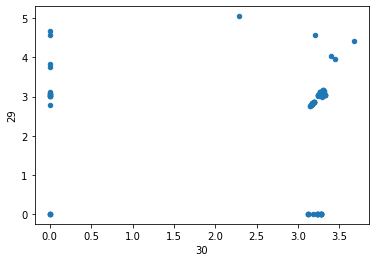

In [140]:
t_ans.plot.scatter(x=30,y=29)

In [ ]:
t_ans.plot.scatter(x=0,y=5)

In [ ]:
#Random sampling bit

# Default scenario
def _generate_sample(pg,qg,pd,qd):
        #Create a model
    model = ConcreteModel()

    model.IDX1 = range(gen_len)
    model.IDX2 = range(bus_len)
    model.Pg = Var(model.IDX2)
    model.Qg = Var(model.IDX2)
    model.t = Var(model.IDX2)
    model.v = Var(model.IDX2)
    
    #Create slack variables
    model.d1 = Var(model.IDX2)
    model.d2 = Var(model.IDX2)
    
     
    # Fix data from generated samples
    for i in model.IDX2:
        model.Pg[i].fix(0) 
        model.Qg[i].fix(0) 

    for i in model.IDX1:
        model.Pg[gen['bus'][i]-1].fix(pg[i])
        model.Qg[gen['bus'][i]-1].fix(qg[i])
        
    # Fix data from generated samples
    var = 1
    for i in model.IDX2:
        if (np.any(gen['bus'].ravel()-1==[i])):
            var = 0
        else:
            model.d1[i].fix(0) 
            model.d2[i].fix(0) 

    # declare constraints
    model.c = ConstraintList()

    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 
        
    for i in model.IDX1:
        model.c.add(expr = model.d1[i] <= Pmax[i]-pg[i])
        model.c.add(expr = model.d1[i] >= Pmin[i]-pg[i]) 
        model.c.add(expr = model.d2[i] <= Qmax[i]-qg[i])
        model.c.add(expr = model.d2[i] >= Qmin[i]-qg[i])

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)


    #Nodal equations
    count = 0
    for i in range(bus_len):
        model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] + pd[i] == model.d1[i])
        model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + qd[i] == model.d2[i])

    #Line flow constraints
    for i in range(len(branch)): 
        x = int(branch.loc[i]['fbus'])-1
        y = int(branch.loc[i]['tbus'])-1
        val = (branch.loc[i]['rateA']/100)
        if(val == 0):
            val = 100
   #    With phasor
        Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
        Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

        Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
        Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

#         if i != 81:
#             model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
#             model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)
        model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
        model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


 #Declare objective function
    model.cost = Objective( 
        expr = sum([model.d1[i]**2 for i in range(gen_len)]) + sum([model.d2[i]**2 for i in range(gen_len)]) 
    ) 

    # solve
    solution = SolverFactory('ipopt').solve(model)
   
    
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        if(model.cost()  >= 0.001):
            result = np.array([(model.Pg[gen['bus'][i]-1].value + model.d1[i].value) for i in range(gen_len)]+[(model.Qg[gen['bus'][i]-1].value + model.d2[i].value) for i in range(gen_len)])
            return result
        else:
            result = np.array([(model.Pg[gen['bus'][i]-1].value) for i in range(gen_len)]+[(model.Qg[gen['bus'][i]-1].value) for i in range(gen_len)])
            return result
        
    else:
        return np.array([1 for i in range(2*gen_len)])

    
    
#Define number of samples
n = 2000

#Generation data
from smt.sampling_methods import LHS
pg = np.array(p)
qg = np.array(q)
sampling_qg = LHS(xlimits=qg)
sampling_pg = LHS(xlimits=pg)
gen_active = sampling_pg(10*n)
gen_reactive = sampling_qg(10*n)

samples = np.zeros(2*gen_len)
k = 0
inf_ = np.array([])

while(1):
    if (len(samples)-len(inf_)-1 == n):
        break
    new_s = _generate_sample(gen_active[k,:], gen_reactive[k,:], a_load.iloc[k].to_numpy(), r_load.iloc[k].to_numpy())
    if new_s is not None:
        if(np.all(new_s == 1)):
            inf_ = np.append(inf_,k)
        samples = np.vstack((samples,new_s))
        k = k + 1
        
df_samples = pd.DataFrame(samples[1:])#.drop(0)
df_samples = df_samples.drop(inf_)
df_samples.columns = ['P%s' %(i+1) for i in range(gen_len)]+['Q%s' %(i+1) for i in range(gen_len)]
t_ans = df_samples[['P13','P10','P5','P9','P2','P15','P16','P11','P8','P1','P7','P14','P6','P12','P3','P4']]
r_ans = df_samples[['Q13','Q10','Q5','Q9','Q2','Q15','Q16','Q11','Q8','Q1','Q7','Q14','Q6','Q12','Q3','Q4']]

data = pd.concat([a_load,r_load],axis=1)
data = data.drop(inf_)[:n]
data.columns = ['P%s' %(i) for i in range(bus_len)]+['Q%s' %(i) for i in range(bus_len)]

Pd_ans = data[['P41','P35','P43','P46','P45','P63','P60','P47','P59','P49',
               'P51','P22','P38','P67','P40','P32','P23','P50','P39','P19','P26','P24',
               'P20','P48','P16','P44','P27','P54','P25','P28','P52','P55','P58','P17','P66']]
Qd_ans = data[['Q41','Q35','Q43','Q46','Q45','Q63','Q60','Q47','Q59','Q49',
               'Q51','Q22','Q38','Q67','Q40','Q32','Q23','Q50','Q39','Q19','Q26','Q24',
               'Q20','Q48','Q16','Q44','Q27','Q54','Q25','Q28','Q52','Q55','Q58','Q17','Q66']]

t_ans.to_csv('Pg-RS.csv')
r_ans.to_csv('Qg-RS.csv')
Pd_ans.to_csv('Pd-RS.csv')
Qd_ans.to_csv('Qd-RS.csv')

In [ ]:
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    set_instance(model,skip_trivial_constraints=True)
    model.Qg = Var(range(bus_len))
    model.t = Var(range(bus_len), initialize=[0 for i in range(bus_len)])
    model.v = Var(range(bus_len), initialize=[1 for i in range(bus_len)])
    model.vars = Var(range(len(input_space)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(len(input_space)):
        model.c.add(expr = model.vars[i] <= input_space.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= input_space.iloc[i]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i])
        model.c.add(expr = model.Qg[i] <= Qmax[i])
        model.c.add(expr = model.Qg[i] >= Qmin[i])
        model.Qg[i].fix(0)
    

    for i in gen_list:
        model.Qg[i].fixed = False

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (i in gen_list):
                holder1 = model.vars[count]
                count = count+1
            else:
                holder1 = 0
#                 holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = branch.from_bus[i]
            y = branch.to_bus[i]
            val = branch.rateA[i]/100
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     
            
            if (value(Pxy) != 0) & (value(Pyx) != 0) :
                model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
                model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)

        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1.0)
#     model.pprint()
    #Code to deactivate non-linear constraints
#     TransformationFactory('contrib.aggregate_vars').apply_to(model)
    
    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(input_space.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(input_space.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(input_space))])
        result1 = np.array([model.Qg[i].value for i in range(gen_len)])
        return result, result1

    else:
        model.vars[primary_var].setlb(input_space.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(input_space.iloc[primary_var]['maximum'])
        return None, None